<a href="https://colab.research.google.com/github/DyanielCX/DLI-Assm/blob/main/Guoxi_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# LSTM URL Classifier (Character-Level, Keras)




In [ ]:

import os, time, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducibility
np.random.seed(42)
random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, optimizers




#Load dataset (GitHub)

In [ ]:
GITHUB_CSV = "https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv"
raw = pd.read_csv(GITHUB_CSV)

# Keep text + label for DL
df = raw[["url", "status"]].dropna().copy()
df["url"] = df["url"].astype(str).str.lower()
y = df["status"].astype(int).values
texts = df["url"].tolist()

# Character-level tokenization

In [ ]:
# Keep punctuation/symbols: set filters="" and char_level=True
tok = Tokenizer(char_level=True, lower=True, filters="")
tok.fit_on_texts(texts)

seqs = tok.texts_to_sequences(texts)
lengths = np.array([len(s) for s in seqs])

# Use 95th percentile as maxlen to avoid over-padding
maxlen = int(np.percentile(lengths, 95))
maxlen = max(maxlen, 64)          # safety floor
print(f"Max sequence length (95th pct): {maxlen}")

X = pad_sequences(seqs, maxlen=maxlen, padding="post", truncating="post")

Max sequence length (95th pct): 131


#Train/Val/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

vocab_size = len(tok.word_index) + 1
print("Vocab size (chars):", vocab_size)

Vocab size (chars): 74


#Build LSTM model

In [ ]:
def build_model_v2(vocab, seq_len, emb_dim=128, lstm_units=128, lr=1e-3):
    inp = layers.Input(shape=(seq_len,), dtype="int32")

    # Embedding + regularization
    x = layers.Embedding(vocab, emb_dim, input_length=seq_len)(inp)
    x = layers.SpatialDropout1D(0.2)(x)

    # Local n-gram features
    x = layers.Conv1D(128, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Deeper sequence modeling
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)

    # Classifier head
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)   # stronger regularization

    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model_v2(vocab_size, maxlen, emb_dim=128, lstm_units=128, lr=1e-3)

es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#Train + measure time

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=8,
    batch_size=128,
    callbacks=[es, rlr],
    verbose=1
)

t1 = time.perf_counter()
train_time_minutes = (t1 - t0) / 60.0


Epoch 1/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6372 - loss: 0.6176 - val_accuracy: 0.7419 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 2/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7878 - loss: 0.4700 - val_accuracy: 0.8066 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 3/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8293 - loss: 0.3908 - val_accuracy: 0.8342 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 4/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8562 - loss: 0.3409 - val_accuracy: 0.8845 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 5/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8923 - loss: 0.2663 - val_accuracy: 0.9059 - val_loss: 0.2290 - learning_rate: 0.0010
Epoch 6/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9035 - loss: 0.2364 - val_accuracy: 0.9094 - val_loss: 0.2188 - learning_rate: 0.0010
Epoch 7/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9151 - loss: 0.2087 - val_accuracy: 0.9121 

Evaluate

In [ ]:
# Prediction time per sample (ms)
t2 = time.perf_counter()
y_proba = model.predict(X_test, batch_size=512).ravel()
t3 = time.perf_counter()
pred_time_ms_per_sample = ((t3 - t2) / len(X_test)) * 1000.0

y_pred = (y_proba >= 0.5).astype(int)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

print("\n=== LSTM Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")
print(f"Train time (min)        : {train_time_minutes:.2f}")
print(f"Prediction time (ms/sample): {pred_time_ms_per_sample:.2f}\n")
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step

=== LSTM Test Metrics ===
Accuracy : 0.9191
Precision: 0.9246
Recall   : 0.9125
F1-score : 0.9185
ROC-AUC  : 0.9740
Train time (min)        : 10.80
Prediction time (ms/sample): 2.61

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9136    0.9256    0.9196      1143
           1     0.9246    0.9125    0.9185      1143

    accuracy                         0.9191      2286
   macro avg     0.9191    0.9191    0.9191      2286
weighted avg     0.9191    0.9191    0.9191      2286



#Plots

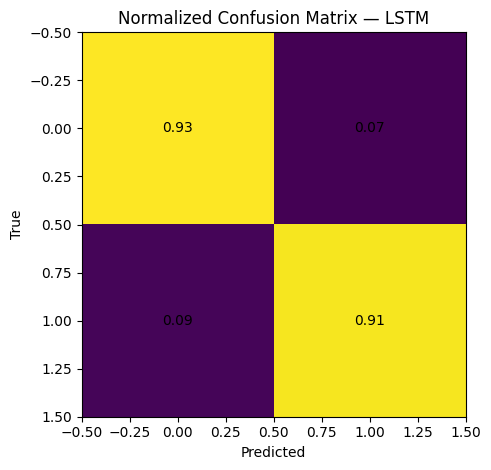

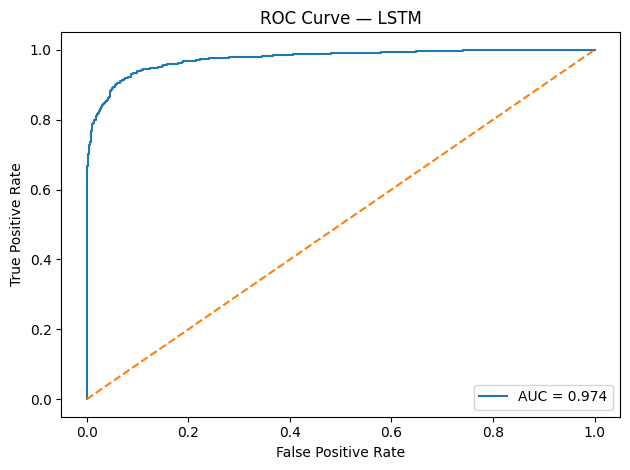

In [ ]:
# Confusion matrix (normalized)
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Normalized Confusion Matrix — LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve — LSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



#Save artifacts


In [ ]:
OUT = Path("outputs_lstm"); OUT.mkdir(exist_ok=True, parents=True)
model.save(OUT / "lstm_url_classifier.h5")

# Save tokenizer
with open(OUT / "tokenizer_charlevel.json", "w") as f:
    f.write(tok.to_json())

# Save metrics
pd.DataFrame([{
    "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-score": f1,
    "ROC-AUC": auc,
    "Training Time (minutes)": train_time_minutes,
    "Prediction Time (milliseconds)": pred_time_ms_per_sample,
    "Maxlen": maxlen, "VocabSize": vocab_size
}]).to_csv(OUT / "metrics_summary.csv", index=False)

#Comapare

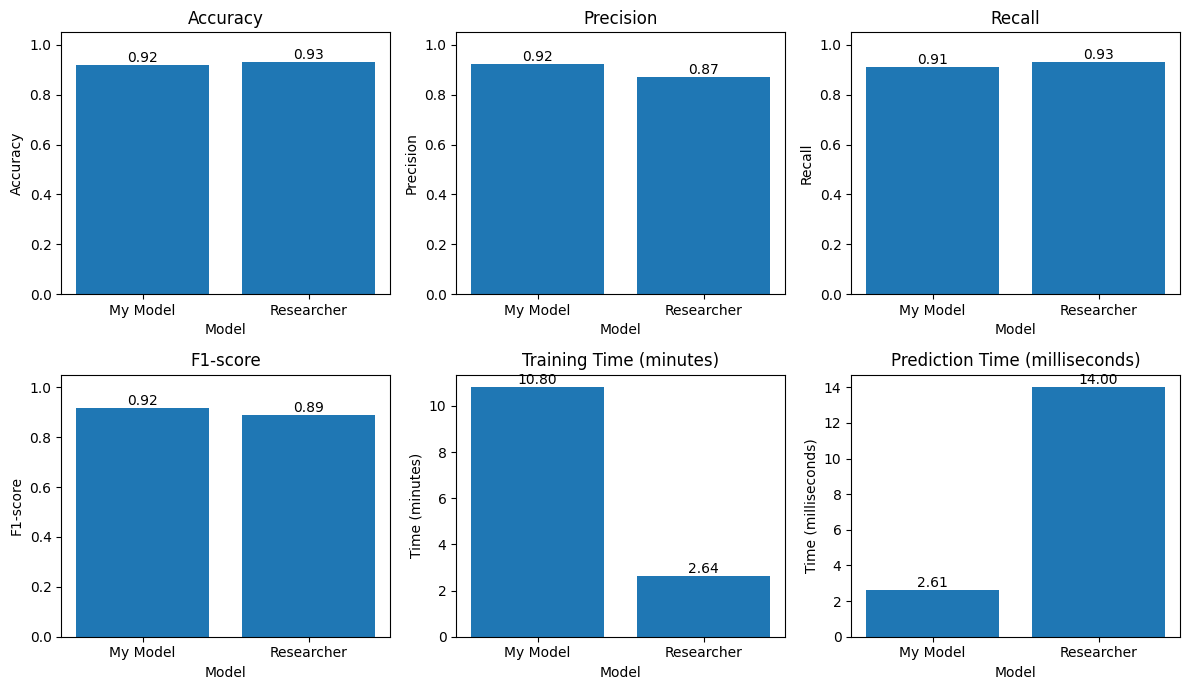

Saved model & files to: /content/outputs_lstm


In [ ]:
RP = {
    "Accuracy": 0.93,
    "Precision": 0.87,
    "Recall": 0.93,
    "F1-score": 0.89,
    "Training Time (minutes)": 2.64,
    "Prediction Time (milliseconds)": 14.00
}
my_vals = [acc, prec, rec, f1, train_time_minutes, pred_time_ms_per_sample]
rp_vals = [RP["Accuracy"], RP["Precision"], RP["Recall"], RP["F1-score"],
           RP["Training Time (minutes)"], RP["Prediction Time (milliseconds)"]]
titles = ["Accuracy","Precision","Recall",
          "F1-score","Training Time (minutes)","Prediction Time (milliseconds)"]

fig, axes = plt.subplots(2,3, figsize=(12,7)); axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.bar(["My Model","Researcher"], [my_vals[i], rp_vals[i]])
    ax.set_title(titles[i]); ax.set_xlabel("Model")
    if i <= 3:
        ax.set_ylim(0, 1.05); ax.set_ylabel(titles[i])
    elif i == 4:
        ax.set_ylabel("Time (minutes)")
    else:
        ax.set_ylabel("Time (milliseconds)")
    for j, v in enumerate([my_vals[i], rp_vals[i]]):
        ax.text(j, v, f"{v:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.savefig(OUT / "comparison_bars.png", dpi=180)
plt.show()

print(f"Saved model & files to: {OUT.resolve()}")